<h1>User 235 of 24 lags, 24 pre-step on LSTM </h1>

<h2>0.Parameters</h2>

In [18]:
import sys ; sys.path.append('../../util') # add utility folder to a system path
from fresh_parameters import parameters

param = parameters(n_repeats=5, 
                   n_data_period = 1, # 0 means 52 wk, 1 means 3 months, 2 means 4 weeks 3 means 1 week and else is 3 days
                   n_lags=24, 
                   n_seq_steps=24, 
                   n_pre_steps=24, n_features=1, 
                   batch_size=168, forcast_batch_size=1,
                   test_size=24 * 7 * 2, 
                   n_epochs=100, 
                   n_neurons=200,
                   b_stateful = False,
                   b_shuffle = False,
                   ratio_rec_dropout = 0.0, # recurrent dropout ratio
                   ratio_input_dropout = 0.2 , # input dropout ratio
                   ratio_validation=0.2,input_folder = "../../input/electricity/",
                   input_file_01 = "elect_235.csv", debug_folder = "../../debug/",
                   b_load_model = False,
                   model_folder = "model_loc/",
                   model_json = "e235_12wk_model.json",
                   model_weight = "e235_12wk_weight.h5" 
                   )

NEURONS = param.n_neurons

In [19]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

IPython.keyboard_manager.command_shortcuts.add_shortcut('alt-r',
  function (event) {
      IPython.notebook.kernel.restart();
      setTimeout(function(){ IPython.notebook.execute_all_cells(); }, 1000);
      return false;
});

<IPython.core.display.Javascript object>

In [20]:
from fresh_general_util import time_start, time_end, set_seed
start_time = time_start() ; set_seed()

<h2>1. Load an input data and preprocess it</h2>

In [21]:
input_file_01_path = param.input_folder + param.input_file_01
print("input_file_01_path: ",input_file_01_path)

input_file_01_path:  ../../input/electricity/elect_235.csv


In [22]:
from fresh_input_preprocess import load_input, get_sample_period, sample_dataset
series_raw = load_input(input_file_01_path)
# aggregate electric spendings by hour
series = series_raw.resample("H").mean() ; #print(series.head())
start_date, end_date = get_sample_period(param.n_data_period)
series = sample_dataset(start_date, end_date, series, param.debug_folder, verbose=True)
series.shape

(2016, 1)

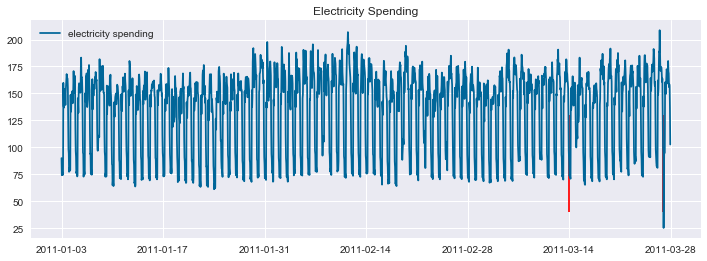

In [23]:
# Show the data set selected
from datetime import date
import matplotlib.pyplot as plt
import seaborn;seaborn.set()
plt.rcParams["figure.figsize"] = [12, 4]
plt.plot(series, label="electricity spending", color = '#006699')
plt.legend(loc='upper left')
plt.title("Electricity Spending")
plt.vlines(x=date(2011,3,14), ymin=40, ymax=130, color='r')
plt.vlines(x=date(2011,3,27), ymin=40, ymax=130, color='r')
plt.show()

<h2>2. Prepare Data using scale abd spliting into train and test</h2>

In [24]:
from fresh_input_preprocess import prepare_data2, split_X_Y
# make a train and test data set scaled
scaler, train_scale, train_raw,val_scale,val_raw, test_scale, test_raw = prepare_data2(series, param,verbose=True)

y_test = test_raw

Shape of train_scale:  (1344, 48)
Shape of train_scale_multiple:  (1344, 48)
Shape of train_raw_multiple:  (1344, 1)
Shape of val_scale:  (168, 48)
Shape of val_scale_multiple:  (168, 48)
Shape of val_raw_multiple:  (168, 1)
Shape of test_scale:  (313, 48)
Shape of test_raw:  (336, 1)


In [25]:
# split X and Y
x_train_scale, y_train_scale = split_X_Y(train_scale, param.n_lags, "train_scale", verbose=True)
x_val_scale, y_val_scale = split_X_Y(val_scale, param.n_lags, "val_scale", verbose=True)
x_test_scale, y_test_scale = split_X_Y(test_scale, param.n_lags, "test_scale", verbose=True)
#print("Shape of x_train_scale: ", x_train_scale.shape)
#print("Shape of y_train_scale: ", y_train_scale.shape)
#print("Shape of x_val_scale: ", x_val_scale.shape)
#print("Shape of y_val_scale: ", y_val_scale.shape)
#print("Shape of x_test_scale: ", x_test_scale.shape)
#print("Shape of y_test_scale: ", y_test_scale.shape)

<h2>3. Make a model and Experiment</h2>

In [26]:
from fresh_model import display_loss_train, save_model, load_model
from fresh_prediction import fit_lstm2, make_forecasts, forecast_lstm, evaluate_mse, invert_scale, convert_prediction
from fresh_prediction import make_mul_index, predict
import numpy as np

In [27]:
def train_experiment(param, neurons, scaler, x_train_scale, y_train_scale, x_val_scale, y_val_scale,x_test_scale, 
               y_test_true, verbose=False):
    error_scores = list()
    best_predictions = list()
    best_error_score = 9999.0
    best_history_list = list()

    
    for r in range(param.n_repeats):
        model, train_history_list = fit_lstm2(x_train_scale, y_train_scale, x_val_scale, y_val_scale,neurons, 
                                             param, verbose=verbose)

        old_weights = model.get_weights() 
        
        rmse, unique_predict_vector = predict(old_weights,param, scaler, 
            x_test_scale, y_test_true, verbose=verbose )    
        
        error_scores.append(rmse)
        if best_error_score > rmse:
            best_error_score = rmse
            best_predictions = unique_predict_vector
            best_history_list = train_history_list
            best_model = model
    
    if(param.b_load_model == False):
        save_model(best_model, param)
                
    return error_scores, best_error_score, best_predictions, y_test_true, best_history_list, best_model

In [28]:
import pandas as pd

results = pd.DataFrame()
best_error_score = 9999
best_predictions = list()
best_history_list = list()

for e in [NEURONS] :
    results[str(e)], error_score, predictions, y_test_true, train_history_list, best_model = train_experiment(param, 
                                                                                            e,
                                                                                            scaler,
                                                                                            x_train_scale, 
                                                                                            y_train_scale,
                                                                                            x_val_scale, 
                                                                                            y_val_scale, 
                                                                                            x_test_scale, 
                                                                                            y_test,
                                                                                            verbose=False)
    if best_error_score > error_score:
        best_error_score = error_score
        best_predictions = predictions
        best_history_list = train_history_list
        
print(results.describe())



# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
TEST RMSE: 14.093
# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
TEST RMSE: 13.901
# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
TEST RMSE: 14.840
# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
TEST RMSE: 13.717
# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
TEST RMSE: 14.241
Saved model to disk
             200
count   5.000000
mean   14.1

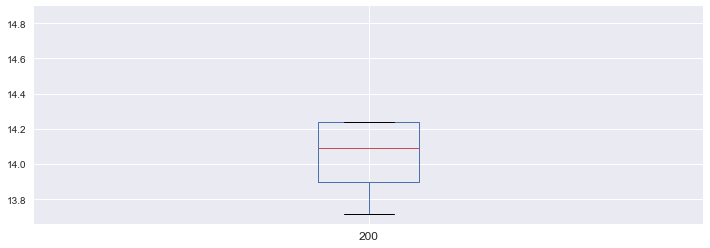

In [29]:
results.boxplot()
plt.show()

<h2>4. Evaluation</h2>

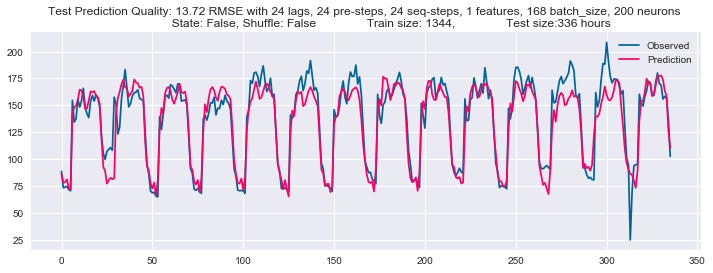

In [30]:
from fresh_prediction import display_obs_pred, evaluate, evaluate_with_model
display_obs_pred("Test", best_error_score, param, 
                     y_test_true, best_predictions, x_train_scale,TEST_SIZE=param.test_size )    

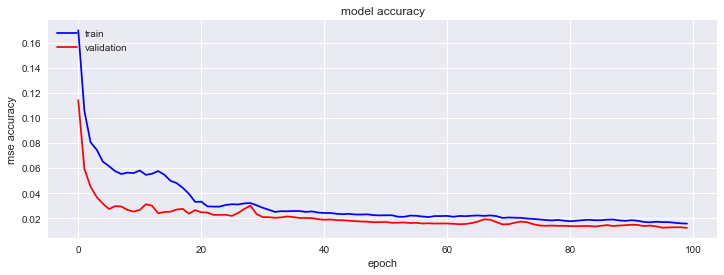

In [31]:
display_loss_train(best_history_list)

TEST RMSE: 52.842


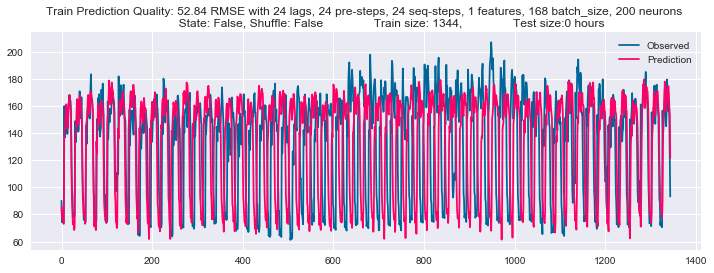

In [32]:
# Evaluate train data    
evaluate_with_model("Train", best_model, param,scaler,
           x_train_scale, train_raw,verbose=False)    
 

TEST RMSE: 51.389


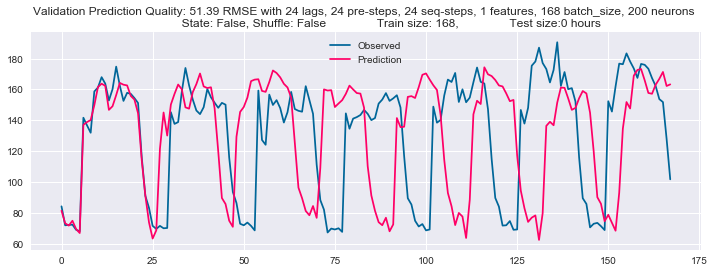

In [33]:
# Evaluate train data    
evaluate_with_model("Validation", best_model,param,scaler,
           x_val_scale, val_raw, verbose=False)   

In [34]:
time_end(start_time)

start time:  1536394940.518848
end time:  1536396752.897563
Total exectution time (Min): 30.206311917304994


<h3>Reference:</h3><br>